In [ ]:
pip install flexpolyline rtree pygeos polyline python-dotenv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import StandardScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import itertools
import requests
import flexpolyline as fp
import folium
from google.colab import drive
from scipy.spatial import cKDTree
import geopandas as gpd
import rtree
import pygeos
from polyline import decode as polyline_decode
from sklearn.neighbors import BallTree
import geopandas as gpd
import os
import time
import requests
import csv
import json
from datetime import datetime
from dotenv import load_dotenv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA COLLECTION PART
## we ran the code on a differnt system

In [ ]:
# HERE API key
load_dotenv()
api_key = os.getenv("data_api_key")
routing_key = os.getenv("routing_api_key")

In [ ]:
os.environ['TZ'] = 'Asia/Riyadh'
time.tzset()


here_API_KEY = api_key

# Define URL and parameters for the traffic data request
here_url = "https://data.traffic.hereapi.com/v7/flow"
params = {
    'in': 'bbox:46.731514,24.691921,46.794685,24.752716',  # Example bounding box
    'locationReferencing': 'olr',
    'apiKey': here_API_KEY,
    'unit': 'metric'
}

# CSV file setup
csv_file = 'traffic_data_2min.csv'

# Define the header for the CSV file
header = ['timestamp', 'location', 'total_length', 'segment_length', 'speed', 'speedUncapped', 'freeFlow', 'jamFactor', 'confidence', 'traversability']

# Initialize the CSV file with the header if it doesn't exist
if not os.path.isfile(csv_file):
    with open(csv_file, mode='w', newline='', encoding='utf-8-sig') as file:
        writer = csv.writer(file)
        writer.writerow(header)

def fetch_and_save_traffic_data():
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    try:
        # Make the GET request to the API
        response = requests.get(here_url, params=params)
        response.raise_for_status()  # Raise an error for bad responses (4xx and 5xx)

        # Parse the JSON response
        data = response.json()
        results = data['results']

        # Open the CSV file in append mode
        with open(csv_file, mode='a', newline='', encoding='utf-8-sig') as file:
            writer = csv.writer(file)

            # Loop through the results and save each result (including sub-segments) to the CSV
            for result in results:
                location = result['location'].get('description', 'Unknown Location')
                total_length = result['location'].get('length', 0)
                current_flow = result['currentFlow']

                if 'subSegments' not in current_flow:
                    segment_length = total_length
                    speed = current_flow['speed']
                    speed_uncapped = current_flow['speedUncapped']
                    free_flow = current_flow['freeFlow']
                    jam_factor = current_flow['jamFactor']
                    confidence = current_flow['confidence']
                    traversability = current_flow['traversability']
                    writer.writerow([timestamp, location, total_length, segment_length, speed, speed_uncapped, free_flow, jam_factor, confidence, traversability])
                else:
                    sub_segments = current_flow['subSegments']
                    for sub_segment in sub_segments:
                        segment_length = sub_segment.get('length', "N/A")
                        speed = sub_segment.get('speed', "N/A")
                        speed_uncapped = sub_segment.get('speedUncapped', "N/A")
                        free_flow = sub_segment.get('freeFlow', "N/A")
                        jam_factor = sub_segment.get('jamFactor', "N/A")
                        confidence = sub_segment.get('confidence', "N/A")
                        traversability = sub_segment.get('traversability', "N/A")
                        writer.writerow([timestamp, location, total_length, segment_length, speed, speed_uncapped, free_flow, jam_factor, confidence, traversability])

        print(f"Data saved for timestamp: {timestamp}")
    except requests.RequestException as e:
        print(f"Request failed: {e}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Run the loop for the specified number of iterations (every 20 minutes)
while True:
    fetch_and_save_traffic_data()
    # Sleep for 2 minutes (2 * 60 = 120 seconds)
    time.sleep(120)

print("Data collection complete.")


In [ ]:
df = pd.read_csv('/content/traffic_data_unique_locations.csv')
df

In [ ]:
import herepy
import pandas as pd
import time


geocoderApi = herepy.GeocoderApi(api_key=data_api_key)

# Function to get latitude and longitude for a given location in Riyadh
def get_lat_lon_riyadh(location):
    try:
        # Append 'Riyadh' to the location query to focus on Riyadh
        full_query = f"{location}, Riyadh, Saudi Arabia"
        response = geocoderApi.free_form(full_query)

        if response.as_dict()['items']:
            position = response.as_dict()['items'][0]['position']
            return position['lat'], position['lng']
        else:
            return None, None
    except Exception as e:
        print(f"Error for location '{location}': {str(e)}")
        return None, None

# Load your CSV file (replace with the path to your file)
file_path = '/content/traffic_data_unique_locations.csv'
df = pd.read_csv(file_path)

# Create new columns for latitude and longitude if they don't exist
if 'latitude' not in df.columns:
    df['latitude'] = None
if 'longitude' not in df.columns:
    df['longitude'] = None

# Loop through each location and get the latitude and longitude
for index, row in df.iterrows():
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        lat, lon = get_lat_lon_riyadh(row['location'])
        df.at[index, 'latitude'] = lat
        df.at[index, 'longitude'] = lon
        print(f"Processed: {row['location']} - Lat: {lat}, Lon: {lon}")
        time.sleep(1)  # Sleep to avoid hitting API rate limits

# Save the updated DataFrame back to the same CSV file (overwrite it)
df.to_csv(file_path, index=False)
print(f"Data saved to the same file: {file_path}")

In [ ]:
# Load the data from both files
file_unique_locations = "/content/traffic_data_unique_locations (2).csv"
file_segmented = "/content/traffic_data_2min (1).csv"

# Read both CSV files
unique_locations_df = pd.read_csv(file_unique_locations)
segmented_df = pd.read_csv(file_segmented)

# Display the first few rows of each dataframe
unique_locations_df

In [ ]:
# Merge the segmented data with unique locations based on the 'location' column
merged_df = segmented_df.merge(unique_locations_df[['location', 'latitude', 'longitude']],
                               on='location', how='left')

# Display the first few rows of the merged dataframe
merged_df


In [ ]:
merged_file_path = "/content/traffic_data_2min (1).csv"
merged_df.to_csv(merged_file_path, index=False)

merged_file_path

In [ ]:
df2 = pd.read_csv('/content/traffic_data_2min (1).csv')

In [ ]:
df2

# EDA PART

In [ ]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/traffic_data_2min.csv")

In [ ]:
# Display basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001494 entries, 0 to 2001493
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       object 
 1   location        object 
 2   total_length    float64
 3   segment_length  float64
 4   speed           float64
 5   speedUncapped   float64
 6   freeFlow        float64
 7   jamFactor       float64
 8   confidence      float64
 9   traversability  object 
 10  latitude        float64
 11  longitude       float64
dtypes: float64(9), object(3)
memory usage: 183.2+ MB


In [ ]:
df.head()  # Show the first few rows of the data

,timestamp,location,total_length,segment_length,speed,speedUncapped,freeFlow,jamFactor,confidence,traversability,latitude,longitude
0,2024-09-17 17:00:07,65/500/طريق الحزام الشرقي,223.0,223.0,12.222222,12.222222,16.111110,2.1,0.98,open,24.68204,46.68725
1,2024-09-17 17:00:07,شارع حفصه بنت عمر,1283.0,914.0,8.611112,8.611112,11.111112,2.4,0.98,open,24.73016,46.76971
2,2024-09-17 17:00:07,شارع حفصه بنت عمر,1283.0,231.0,5.277778,5.277778,10.833334,1.1,0.98,open,24.73016,46.76971
3,2024-09-17 17:00:07,شارع حفصه بنت عمر,1283.0,138.0,5.000000,5.000000,6.944445,2.9,0.98,open,24.73016,46.76971
4,2024-09-17 17:00:07,شارع خالد بن الوليد واجهة,428.0,269.0,11.666667,11.666667,12.777778,1.0,0.84,open,24.74765,46.77492


In [ ]:
df.describe()  # Show summary statistics of numerical columns

,total_length,segment_length,speed,speedUncapped,freeFlow,jamFactor,confidence,latitude,longitude
count,2.001494e+06,2.001494e+06,1.998426e+06,1.998426e+06,2.001494e+06,2.001494e+06,1.991480e+06,2.001494e+06,2.001494e+06
mean,7.375656e+02,5.262315e+02,1.092629e+01,1.105128e+01,1.319355e+01,1.861031e+00,8.408109e-01,2.472022e+01,4.676324e+01
std,6.046521e+02,5.066426e+02,5.297255e+00,5.498532e+00,4.598320e+00,2.139455e+00,1.075953e-01,1.073278e-01,2.054321e-01
min,9.000000e+00,9.000000e+00,2.777778e-01,2.777778e-01,2.777778e+00,0.000000e+00,7.000000e-01,2.412648e+01,4.535352e+01
25%,2.570000e+02,1.540000e+02,7.500000e+00,7.500000e+00,1.027778e+01,0.000000e+00,7.300000e-01,2.468925e+01,4.675148e+01
50%,7.000000e+02,3.820000e+02,9.722222e+00,9.722222e+00,1.194444e+01,1.300000e+00,8.400000e-01,2.472004e+01,4.676542e+01
75%,1.010000e+03,7.940000e+02,1.277778e+01,1.305556e+01,1.611111e+01,2.900000e+00,9.500000e-01,2.474676e+01,4.677930e+01
max,4.183000e+03,4.183000e+03,3.333334e+01,4.500000e+01,2.833333e+01,1.000000e+01,9.900000e-01,2.592735e+01,4.958791e+01


In [ ]:
# Check for missing values
print("Missing values in each column:")
print(df.isna().sum())

Missing values in each column:
timestamp             0
location              0
total_length          0
segment_length        0
speed              3068
speedUncapped      3068
freeFlow              0
jamFactor             0
confidence        10014
traversability        0
latitude              0
longitude             0
dtype: int64


In [ ]:
# Display unique locations to understand data diversity
print("Unique locations in the dataset:")
print(df['location'].nunique())

Unique locations in the dataset:
91


In [ ]:
# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract useful features from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['isWeekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df['Diff_jamFactor'] = df['jamFactor'].diff()

# Convert speed to speed_kmh
df['speed_kmh'] = df['speed'] * 3.6

df['freeFlow_kmh'] = df['freeFlow'] * 3.6

lag_features = [1, 2, 3]  # we added three days of lagged jamfactor
for lag in lag_features:
    df[f'jamFactor_lag_{lag}'] = df['jamFactor'].shift(lag)

window = [30, 30*5, 30*10]

for window in window:
    df[f'jamFactor_ma{window}'] = df['jamFactor'].rolling(window=window).mean()

# Display the first few rows to verify the new features
print(df.head())

            timestamp                   location  total_length  \
0 2024-09-17 17:00:07  65/500/طريق الحزام الشرقي         223.0   
1 2024-09-17 17:00:07          شارع حفصه بنت عمر        1283.0   
2 2024-09-17 17:00:07          شارع حفصه بنت عمر        1283.0   
3 2024-09-17 17:00:07          شارع حفصه بنت عمر        1283.0   
4 2024-09-17 17:00:07  شارع خالد بن الوليد واجهة         428.0   

   segment_length      speed  speedUncapped   freeFlow  jamFactor  confidence  \
0           223.0  12.222222      12.222222  16.111110        2.1        0.98   
1           914.0   8.611112       8.611112  11.111112        2.4        0.98   
2           231.0   5.277778       5.277778  10.833334        1.1        0.98   
3           138.0   5.000000       5.000000   6.944445        2.9        0.98   
4           269.0  11.666667      11.666667  12.777778        1.0        0.84   

  traversability  ...  isWeekend  Diff_jamFactor  speed_kmh  freeFlow_kmh  \
0           open  ...          0       

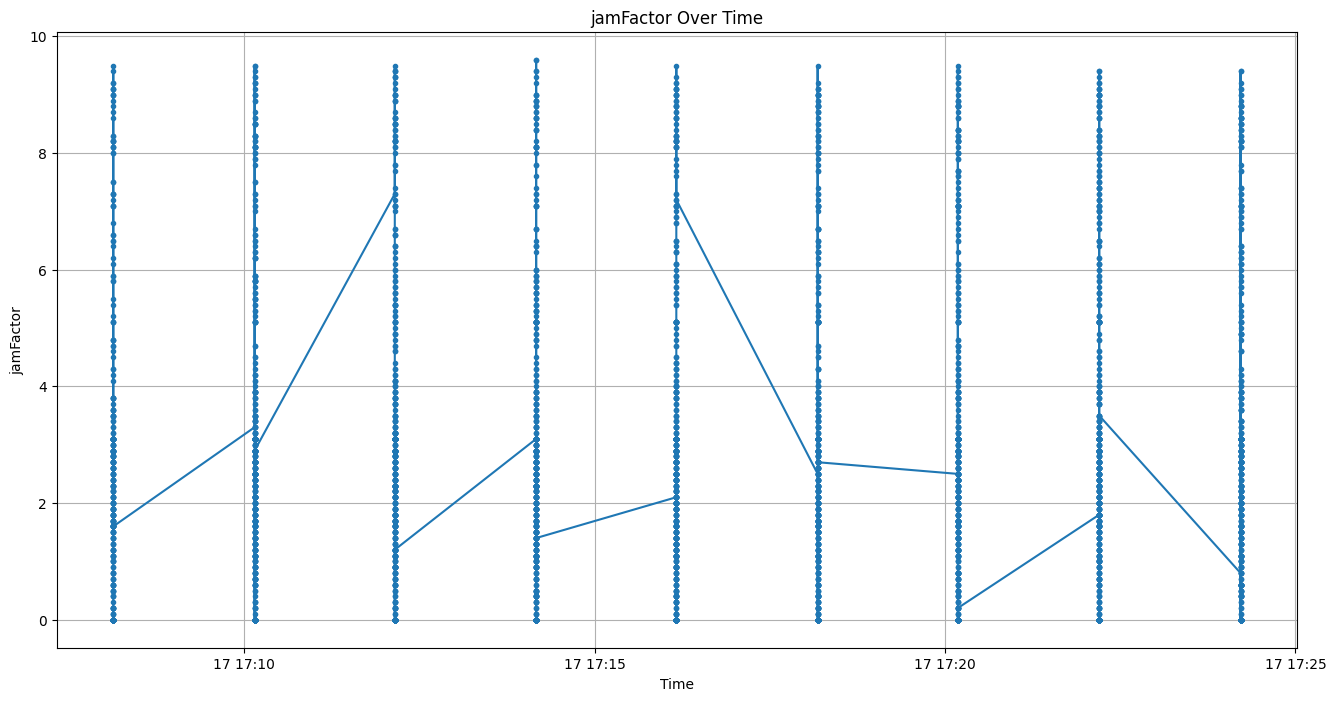

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['timestamp'][2000:6000], df['jamFactor'][2000:6000], marker='.')
plt.title('jamFactor Over Time')
plt.xlabel('Time')
plt.ylabel('jamFactor')
plt.grid(True)
plt.show()

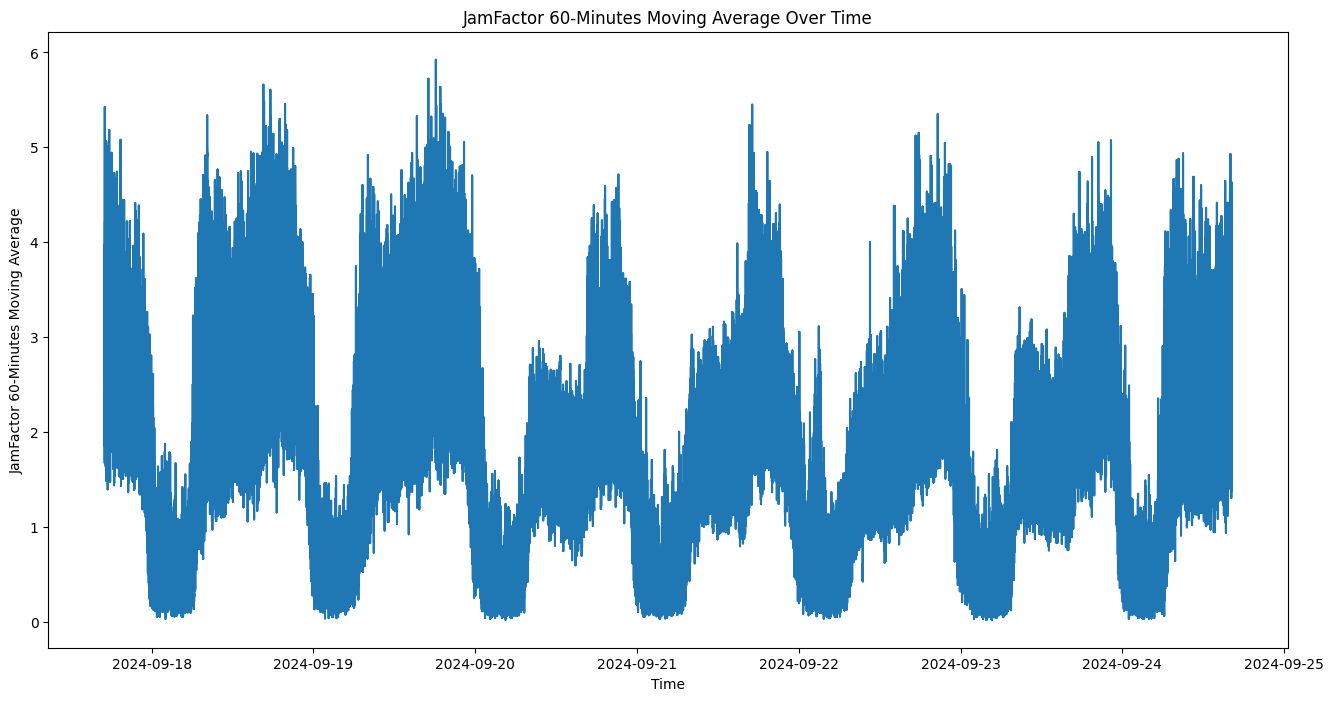

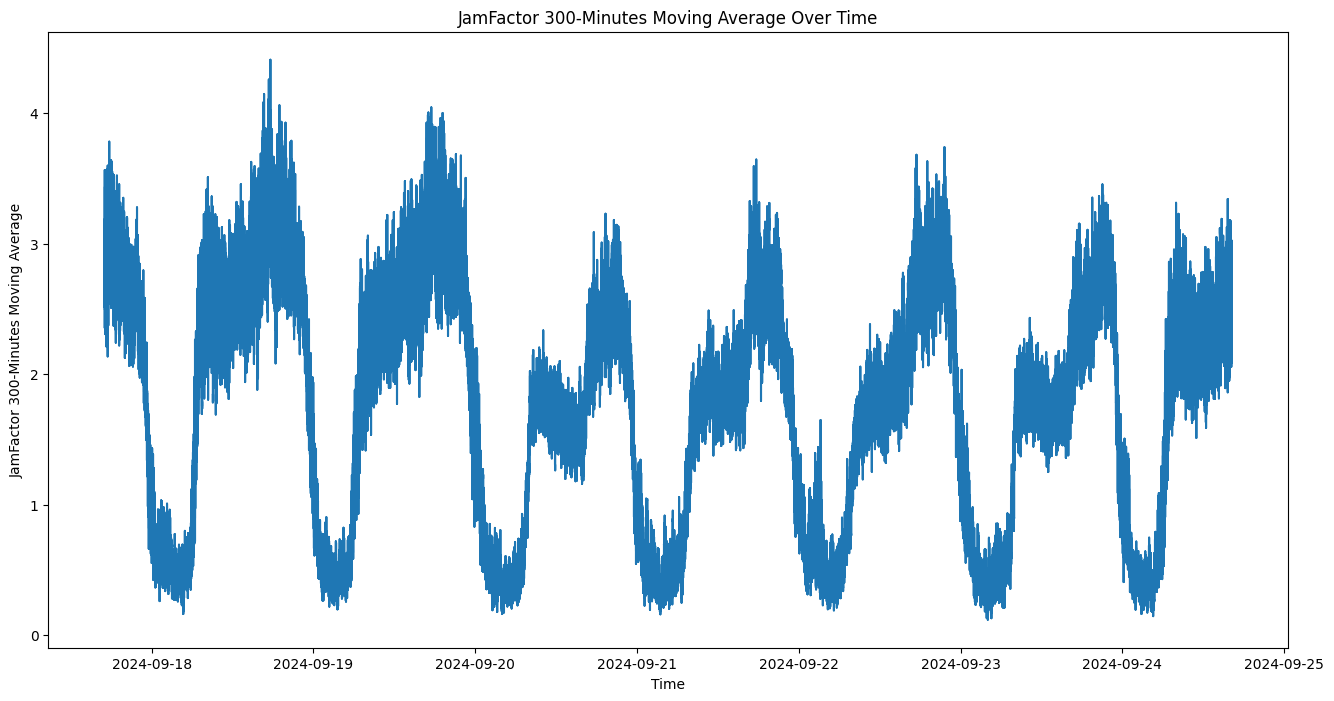

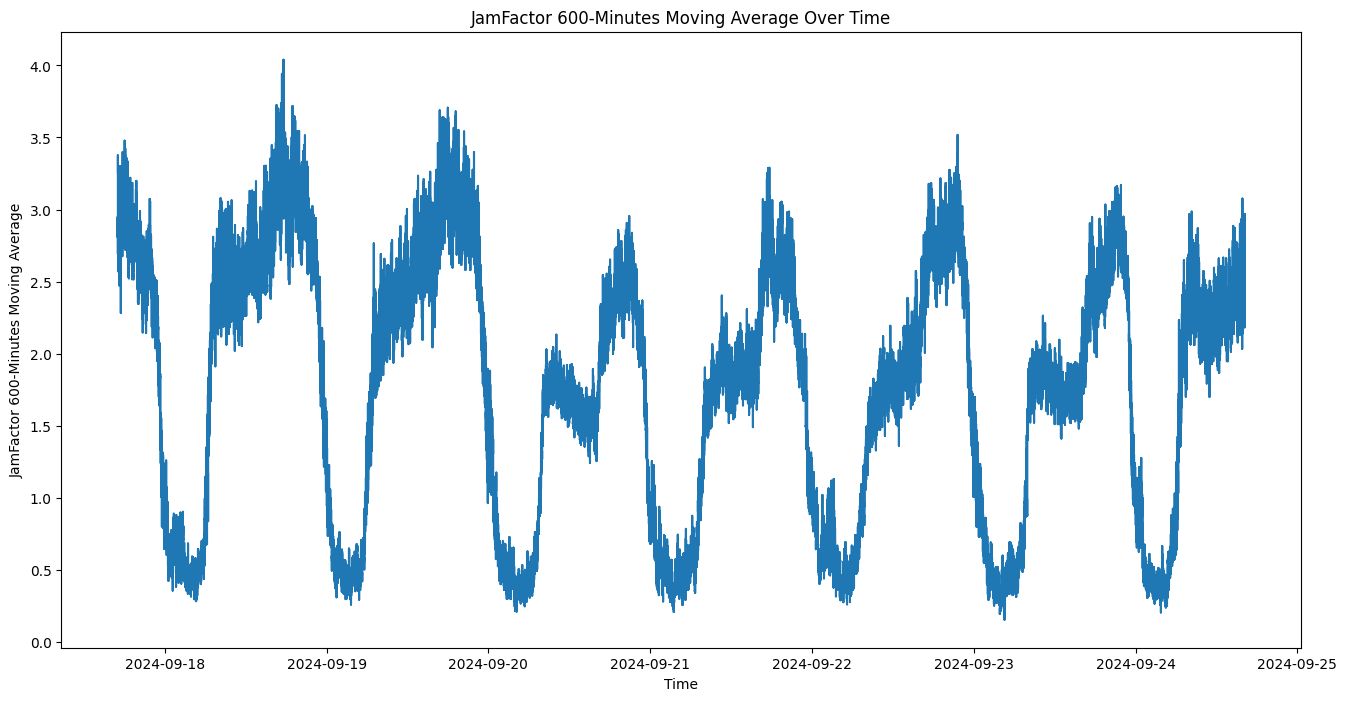

In [ ]:
window = [30, 30*5, 30*10]
for window in window:
    plt.figure(figsize=(16,8))
    plt.plot(df['timestamp'], df[f'jamFactor_ma{window}'])
    plt.title(f'JamFactor {window * 2}-Minutes Moving Average Over Time')
    plt.xlabel('Time')
    plt.ylabel(f'JamFactor {window * 2}-Minutes Moving Average')
    plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


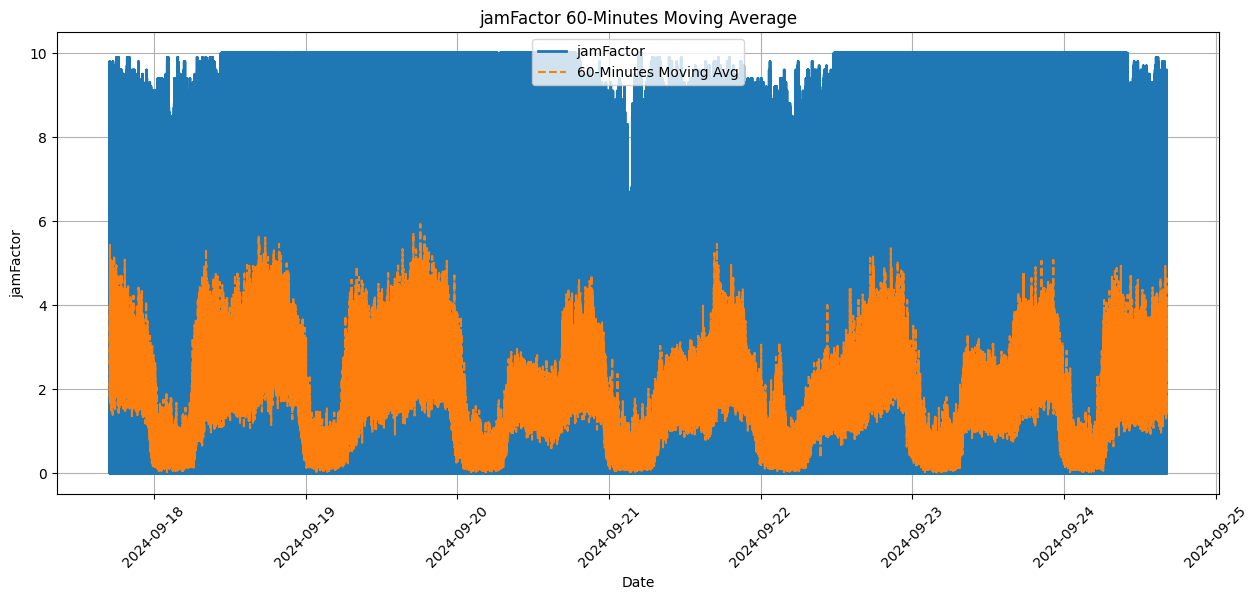

In [ ]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['jamFactor'], label='jamFactor', linewidth=2)
plt.plot(df['timestamp'], df['jamFactor'].rolling(window=window).mean(), label=f'{window * 2}-Minutes Moving Avg', linestyle='--')
plt.title(f'jamFactor {window * 2}-Minutes Moving Average')
plt.xlabel('Date')
plt.ylabel('jamFactor')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

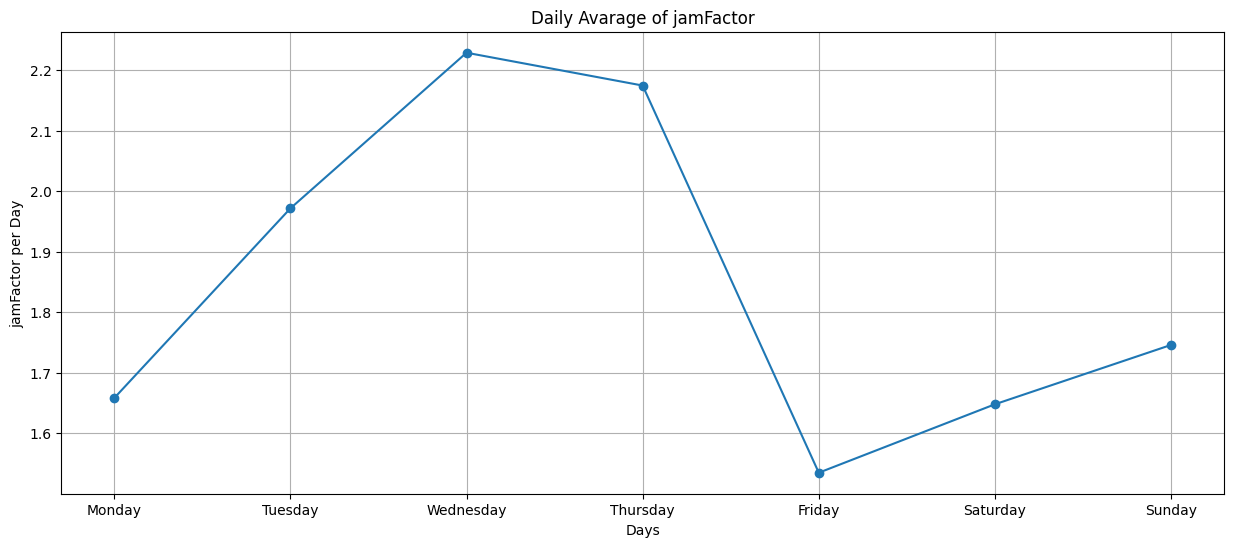

In [ ]:
daily_average = df.groupby('day_of_week')['jamFactor'].mean()

plt.figure(figsize=(15, 6))
plt.plot(daily_average.index, daily_average.values, marker='o')
plt.title(f'Daily Avarage of jamFactor')
plt.xlabel('Days')
plt.ylabel('jamFactor per Day')
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()

In [ ]:
df.columns

Index(['timestamp', 'location', 'total_length', 'segment_length', 'speed',
       'speedUncapped', 'freeFlow', 'jamFactor', 'confidence',
       'traversability', 'latitude', 'longitude', 'hour', 'day_of_week',
       'week_of_year', 'isWeekend', 'Diff_jamFactor', 'speed_kmh',
       'freeFlow_kmh', 'jamFactor_lag_1', 'jamFactor_lag_2', 'jamFactor_lag_3',
       'jamFactor_ma30', 'jamFactor_ma150', 'jamFactor_ma300'],
      dtype='object')

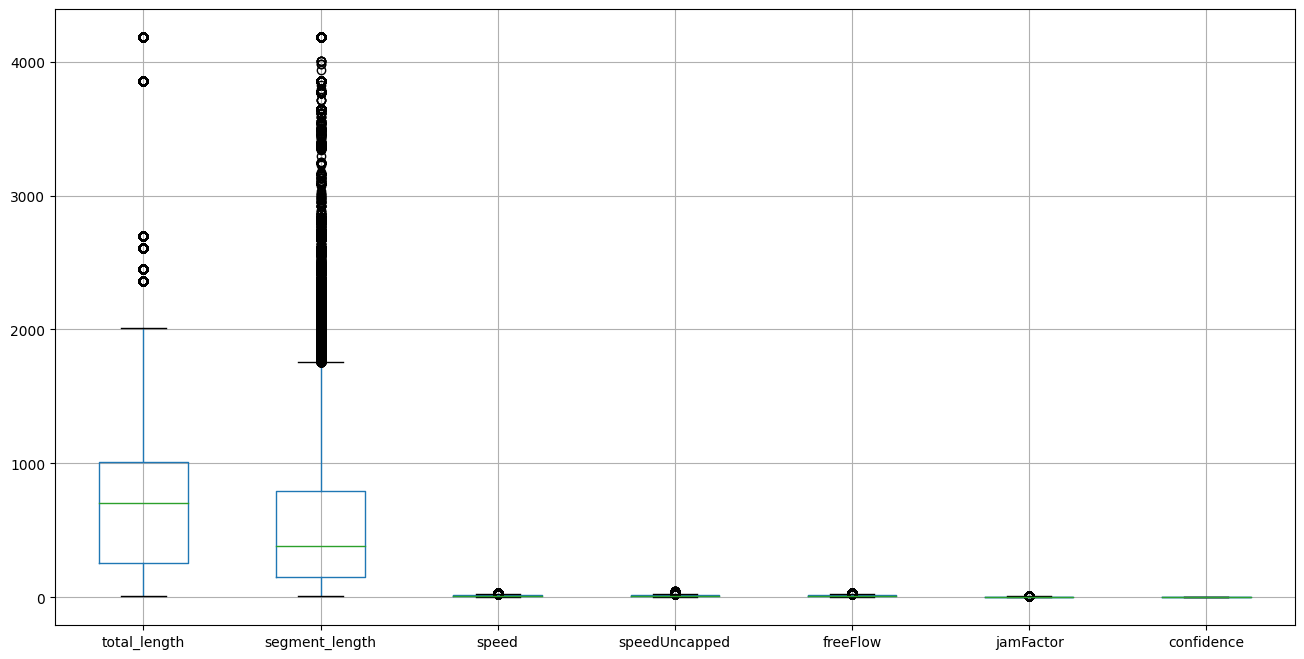

In [ ]:
df.boxplot(figsize=(16,8), column=['total_length', 'segment_length', 'speed', 'speedUncapped', 'freeFlow',
                                   'jamFactor', 'confidence', 'traversability'])
plt.show()

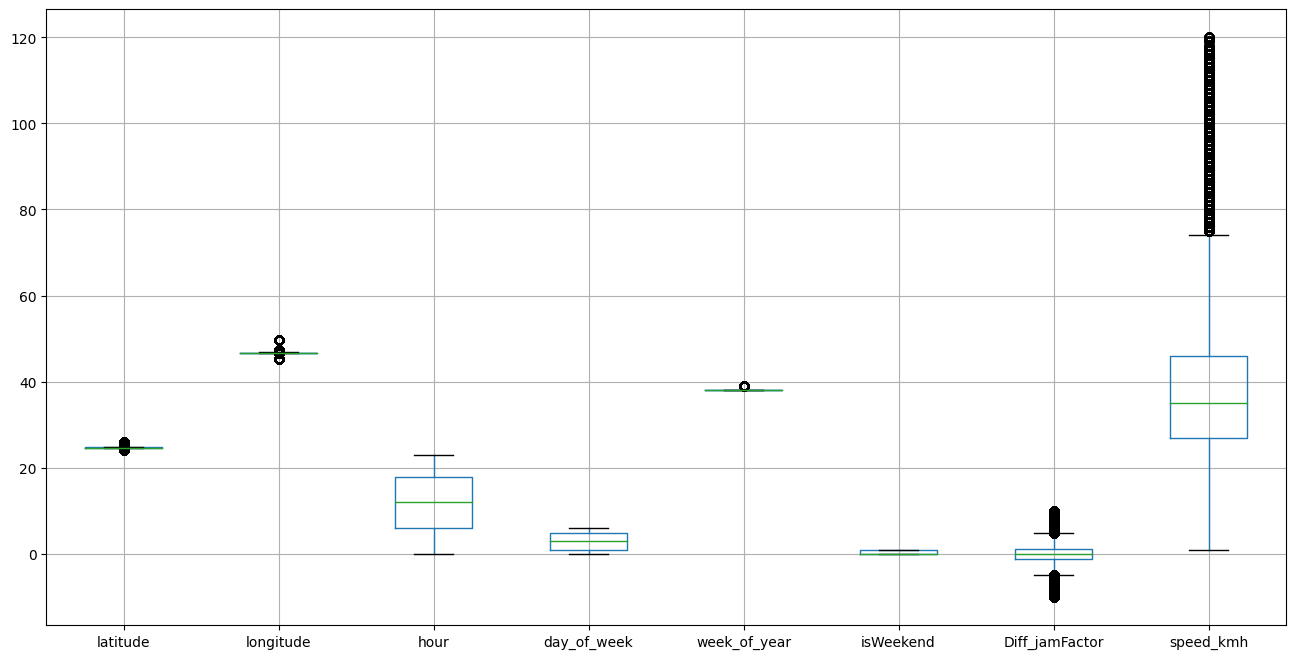

In [ ]:
df.boxplot(figsize=(16,8), column=['latitude', 'longitude', 'hour', 'day_of_week',
       'week_of_year', 'isWeekend', 'Diff_jamFactor', 'speed_kmh'])
plt.show()

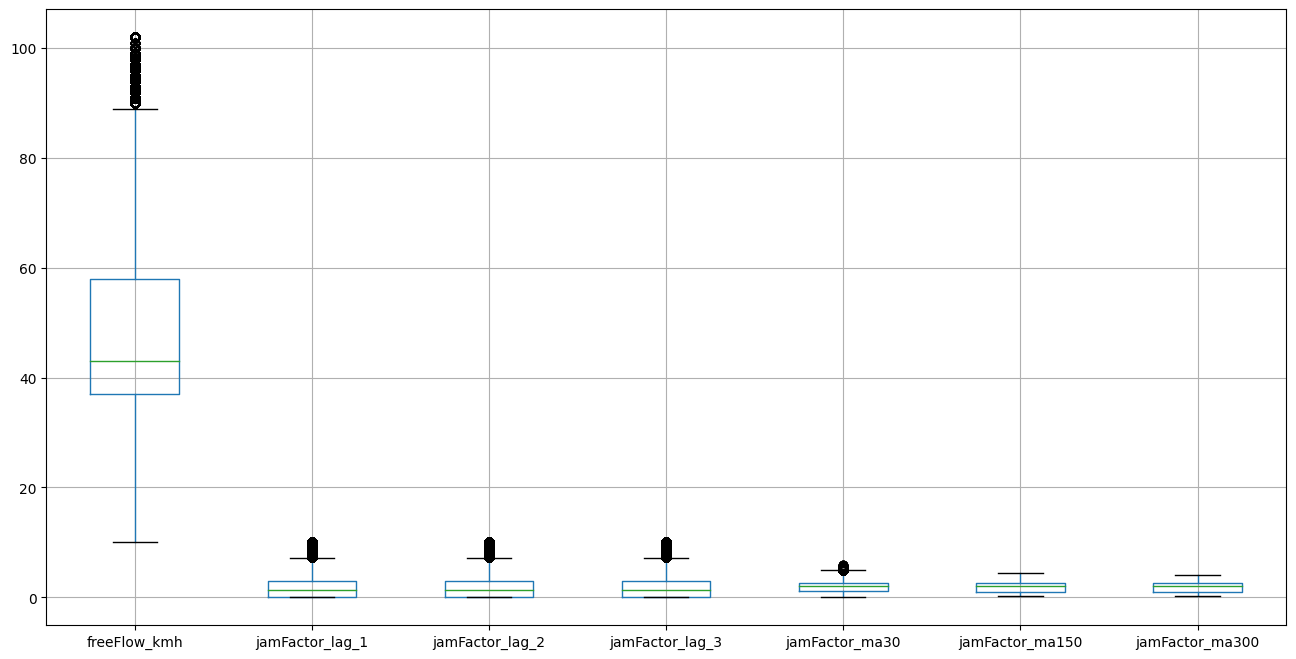

In [ ]:
df.boxplot(figsize=(16,8), column=['freeFlow_kmh', 'jamFactor_lag_1', 'jamFactor_lag_2', 'jamFactor_lag_3',
       'jamFactor_ma30', 'jamFactor_ma150', 'jamFactor_ma300'])
plt.show()

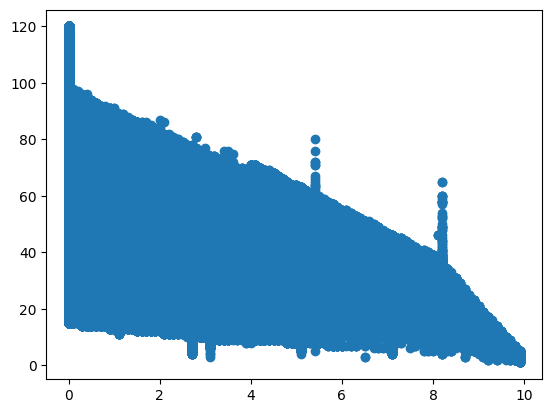

In [ ]:
plt.scatter(df['jamFactor'], df['speed_kmh'])
plt.show()

In [ ]:
# Find the row with the minimum free flow speed
min_freeflow_row = df.loc[df['freeFlow_kmh'].idxmin()]

# Extract the road name and free flow speed
road_name = min_freeflow_row['location']
min_freeflow_speed = min_freeflow_row['freeFlow_kmh']

print(f"The road with the least free flow speed is: {road_name}")
print(f"The minimum free flow speed is: {min_freeflow_speed} km/h")


The road with the least free flow speed is: Unknown Location
The minimum free flow speed is: 10.0000008 km/h


In [ ]:
# Find the row with the minimum free flow speed
min_freeflow_row = df.loc[df['speed_kmh'].idxmin()]

# Extract the road name and free flow speed
road_name = min_freeflow_row['location']
min_freeflow_speed = min_freeflow_row['speed_kmh']

print(f"The road with the least speed is: {road_name}")
print(f"The minimum speed is: {min_freeflow_speed} km/h")


The road with the least speed is: طريق العروبة/الطريق الدائري الشرقي الواجهة
The minimum speed is: 1.0000000800000002 km/h


In [ ]:
max_jam_factor_row = df.loc[df['jamFactor'].idxmax()]
print(f"The road with the highest jam factor is: {max_jam_factor_row['location']} with a jam factor of {max_jam_factor_row['jamFactor']}")


The road with the highest jam factor is: طريق الأمير سعد بن عبدالرحمن الأول with a jam factor of 10.0


In [ ]:
# Fill missing values in 'speed', 'speedUncapped' and confidence with their respective median values

df.fillna({'speed': df['speed'].median(),
           'speedUncapped': df['speedUncapped'].median(),
           'confidence': df['confidence'].median()},
          inplace=True)

# Verify that there are no missing values left
print("Missing values after filling:")
print(df.isna().sum())


Missing values after filling:
timestamp             0
location              0
total_length          0
segment_length        0
speed                 0
speedUncapped         0
freeFlow              0
jamFactor             0
confidence            0
traversability        0
latitude              0
longitude             0
hour                  0
day_of_week           0
week_of_year          0
isWeekend             0
Diff_jamFactor        1
speed_kmh          3068
freeFlow_kmh          0
jamFactor_lag_1       1
jamFactor_lag_2       2
jamFactor_lag_3       3
jamFactor_ma30       29
jamFactor_ma150     149
jamFactor_ma300     299
dtype: int64


In [ ]:
# Fill missing values in 'confidence' with median value

df.fillna({'speed_kmh': df['speed_kmh'].median(),
           'jamFactor_ma30': df['jamFactor_ma30'].median(),
           'jamFactor_ma150': df['jamFactor_ma150'].median(),
           'jamFactor_ma300': df['jamFactor_ma300'].median()},
          inplace=True)

df.isna().sum()

,0
timestamp,0
location,0
total_length,0
segment_length,0
speed,0
speedUncapped,0
freeFlow,0
jamFactor,0
confidence,0
traversability,0


In [ ]:
df.fillna({'jamFactor_lag_1': df['jamFactor_lag_1'].mean(),
           'jamFactor_lag_2': df['jamFactor_lag_2'].mean(),
           'jamFactor_lag_3': df['jamFactor_lag_3'].mean(),
           'Diff_jamFactor': df['Diff_jamFactor'].mean()},
          inplace=True)

print(df.isna().sum())

timestamp          0
location           0
total_length       0
segment_length     0
speed              0
speedUncapped      0
freeFlow           0
jamFactor          0
confidence         0
traversability     0
latitude           0
longitude          0
hour               0
day_of_week        0
week_of_year       0
isWeekend          0
Diff_jamFactor     0
speed_kmh          0
freeFlow_kmh       0
jamFactor_lag_1    0
jamFactor_lag_2    0
jamFactor_lag_3    0
jamFactor_ma30     0
jamFactor_ma150    0
jamFactor_ma300    0
dtype: int64


In [ ]:
# Encode 'location' and 'traversability' columns
oe = OrdinalEncoder()
df[['location_encoded', 'traversability_encoded']] = oe.fit_transform(df[['location', 'traversability']])

# Verify the encoded columns
print(df[['location', 'traversability', 'location_encoded', 'traversability_encoded']].head())


                    location traversability  location_encoded  \
0  65/500/طريق الحزام الشرقي           open              13.0   
1          شارع حفصه بنت عمر           open              56.0   
2          شارع حفصه بنت عمر           open              56.0   
3          شارع حفصه بنت عمر           open              56.0   
4  شارع خالد بن الوليد واجهة           open              58.0   

   traversability_encoded  
0                     1.0  
1                     1.0  
2                     1.0  
3                     1.0  
4                     1.0  


In [ ]:
df.set_index('timestamp', inplace=True)
df.head()

,location,total_length,segment_length,speed,speedUncapped,freeFlow,jamFactor,confidence,traversability,latitude,...,speed_kmh,freeFlow_kmh,jamFactor_lag_1,jamFactor_lag_2,jamFactor_lag_3,jamFactor_ma30,jamFactor_ma150,jamFactor_ma300,location_encoded,traversability_encoded
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-17 17:00:07,65/500/طريق الحزام الشرقي,223.0,223.0,12.222222,12.222222,16.111110,2.1,0.98,open,24.68204,...,43.999999,57.999996,1.861032,1.861033,1.861034,1.943333,1.994667,1.991667,13.0,1.0
2024-09-17 17:00:07,شارع حفصه بنت عمر,1283.0,914.0,8.611112,8.611112,11.111112,2.4,0.98,open,24.73016,...,31.000003,40.000003,2.100000,1.861033,1.861034,1.943333,1.994667,1.991667,56.0,1.0
2024-09-17 17:00:07,شارع حفصه بنت عمر,1283.0,231.0,5.277778,5.277778,10.833334,1.1,0.98,open,24.73016,...,19.000001,39.000002,2.400000,2.100000,1.861034,1.943333,1.994667,1.991667,56.0,1.0
2024-09-17 17:00:07,شارع حفصه بنت عمر,1283.0,138.0,5.000000,5.000000,6.944445,2.9,0.98,open,24.73016,...,18.000000,25.000001,1.100000,2.400000,2.100000,1.943333,1.994667,1.991667,56.0,1.0
2024-09-17 17:00:07,شارع خالد بن الوليد واجهة,428.0,269.0,11.666667,11.666667,12.777778,1.0,0.84,open,24.74765,...,42.000001,46.000001,2.900000,1.100000,2.400000,1.943333,1.994667,1.991667,58.0,1.0


In [ ]:
# Drop the original categorical columns 'location' and 'traversability'
df = df.drop(['location', 'traversability'], axis=1)

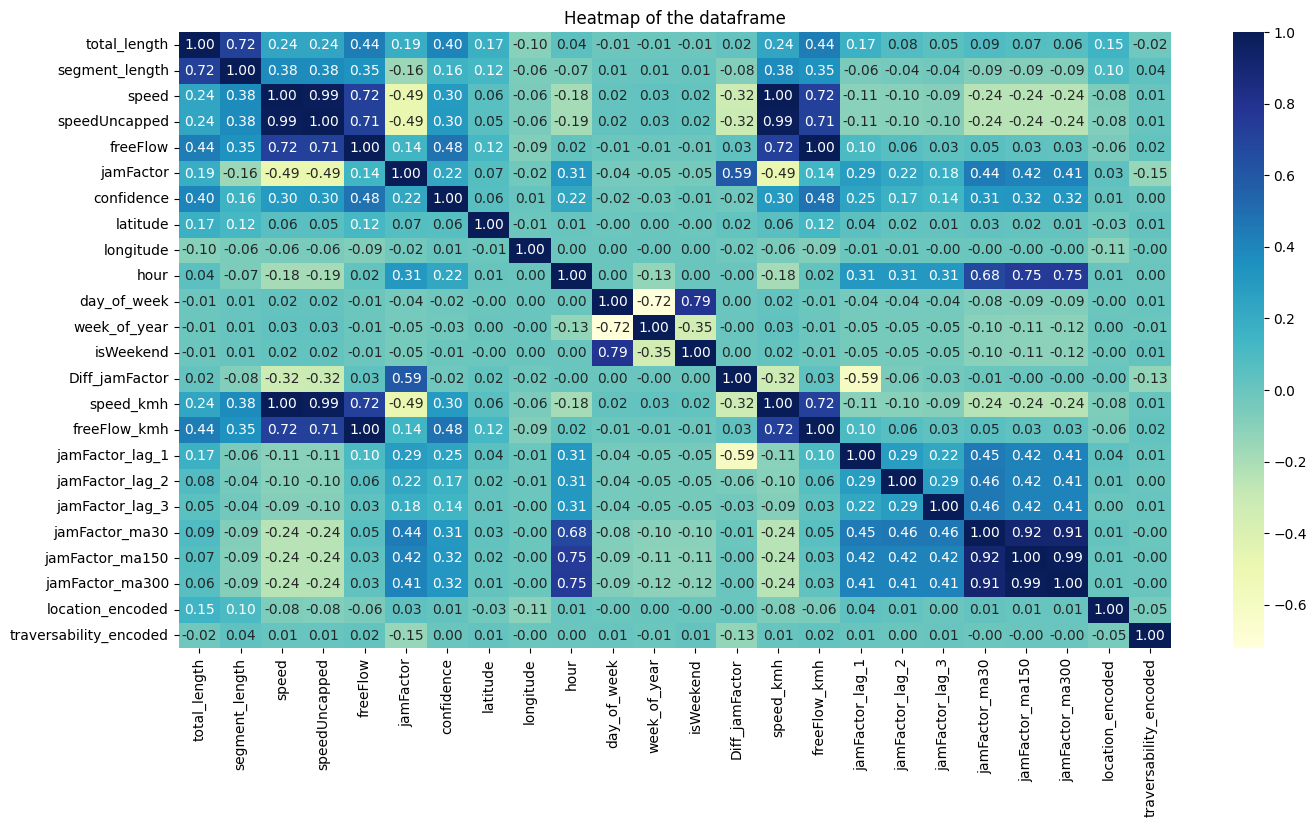

In [ ]:
# Create the heatmap
plt.figure(figsize=(16, 8))

corr = df.corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt='.2f')

# Set the title with the selected street
plt.title("Heatmap of the dataframe")

# Display the plot
plt.show()


# DATA SPLITTING

In [ ]:
# Split data into train, validation, and test sets
train, temp = train_test_split(df, test_size=0.3, shuffle=False)  # 70% train, 30% temp
val, test = train_test_split(temp, test_size=0.5, shuffle=False)  # 15% val, 15% test

# Display the sizes of each set
print(f"Training Samples: {len(train)}")
print(f"Validation Samples: {len(val)}")
print(f"Test Samples: {len(test)}")


Training Samples: 1401045
Validation Samples: 300224
Test Samples: 300225


In [ ]:
train.columns

Index(['total_length', 'segment_length', 'speed', 'speedUncapped', 'freeFlow',
       'jamFactor', 'confidence', 'latitude', 'longitude', 'hour',
       'day_of_week', 'week_of_year', 'isWeekend', 'Diff_jamFactor',
       'speed_kmh', 'freeFlow_kmh', 'jamFactor_lag_1', 'jamFactor_lag_2',
       'jamFactor_lag_3', 'jamFactor_ma30', 'jamFactor_ma150',
       'jamFactor_ma300', 'location_encoded', 'traversability_encoded'],
      dtype='object')

In [ ]:
# Choose the columns to use as features, excluding the dropped ones
features = ['total_length','speedUncapped', 'latitude', 'longitude', 'hour',
            'day_of_week', 'week_of_year', 'isWeekend', 'Diff_jamFactor',
            'speed_kmh', 'freeFlow_kmh', 'jamFactor_lag_1', 'jamFactor_lag_2',
            'jamFactor_ma30', 'jamFactor_ma150',
            'jamFactor_ma300', 'location_encoded']

targets = ['jamFactor']

# Convert to numpy arrays for TensorFlow input
X_train_np = train[features].values
y_train_np = train[targets].values

X_test_np = test[features].values
y_test_np = test[targets].values

X_val_np = val[features].values
y_val_np = val[targets].values

sequence_length = 10  # Adjust this as needed

# Scale features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled = scaler.transform(X_val_np)
X_test_scaled = scaler.transform(X_test_np)

# scale the target (y)
y_scaler = StandardScaler()

# Fit the scaler on training target values and transform targets
y_train_scaled = y_scaler.fit_transform(y_train_np)
y_val_scaled = y_scaler.transform(y_val_np)
y_test_scaled = y_scaler.transform(y_test_np)

# Handle NaNs in the test set (if needed)
X_test_np = np.nan_to_num(X_test_np)

In [ ]:
print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape, X_val_scaled.shape, y_val_scaled.shape)

(1401045, 17) (1401045, 1) (300225, 17) (300225, 1) (300224, 17) (300224, 1)


In [ ]:
# Create time series datasets
train_dataset = timeseries_dataset_from_array(
    data=X_train_scaled,
    targets=y_train_scaled,
    sequence_length=sequence_length,
    shuffle=False
)

# Create time series datasets
test_dataset = timeseries_dataset_from_array(
    data=X_test_scaled,
    targets=y_test_scaled,
    sequence_length=sequence_length,
    shuffle=False
)

# Create time series datasets
val_dataset = timeseries_dataset_from_array(
    data=X_val_scaled,
    targets=y_val_scaled,
    sequence_length=sequence_length,
    shuffle=False
)

In [ ]:
print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape, X_val_scaled.shape, y_val_scaled.shape)

(1401045, 17) (1401045, 1) (300225, 17) (300225, 1) (300224, 17) (300224, 1)


# MODEL DEVELOPMENT

In [ ]:
window_len = 10
num_features = X_train_scaled.shape[1]

# Define the model with LSTM layers
model = Sequential([
    # First LSTM layer
    LSTM(16, return_sequences=True, input_shape=(window_len, num_features), kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(8, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

     # First Dense layer with Batch Normalization
    Dense(4, activation='relu'),
    BatchNormalization(),

    # Final output layer
    Dense(1, activation='linear')  # Use 'linear' for continuous values
])

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print the model summary to verify the architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 16)              │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4)                   │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,033 (11.85 KB)

 Trainable params: 3,025 (11.82 KB)

 Non-trainable params: 8 (32.00 B)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(train_dataset,
                    validation_data=(val_dataset),
                    epochs=50,
                    batch_size=32,  # Adjust batch size based on available hardware
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

Epoch 1/50
10944/10946 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3938 - mae: 0.3146
Epoch 1: val_loss improved from inf to 0.43927, saving model to /content/drive/MyDrive/best_model.keras
10946/10946 ━━━━━━━━━━━━━━━━━━━━ 397s 36ms/step - loss: 0.3937 - mae: 0.3145 - val_loss: 0.4393 - val_mae: 0.6034
Epoch 2/50
10943/10946 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0407 - mae: 0.1405
Epoch 2: val_loss did not improve from 0.43927
10946/10946 ━━━━━━━━━━━━━━━━━━━━ 357s 33ms/step - loss: 0.0407 - mae: 0.1405 - val_loss: 0.4757 - val_mae: 0.6332
Epoch 3/50
10944/10946 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0352 - mae: 0.1332
Epoch 3: val_loss improved from 0.43927 to 0.38037, saving model to /content/drive/MyDrive/best_model.keras
10946/10946 ━━━━━━━━━━━━━━━━━━━━ 358s 33ms/step - loss: 0.0352 - mae: 0.1332 - val_loss: 0.3804 - val_mae: 0.5674
Epoch 4/50
10946/10946 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0293 - mae: 0.1218
Epoch 4: val_loss improved from 0.38037 to 0.24220, sav

In [ ]:
# Save the trained model to a file
with open('/content/drive/MyDrive/trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as trained_model.pkl")


In [ ]:
# save scaling file
joblib.dump(scaler, '/content/drive/MyDrive/feature_scaler.pkl')
joblib.dump(y_scaler, '/content/drive/MyDrive/target_scaler.pkl')


['/content/drive/MyDrive/target_scaler.pkl']

In [ ]:
# Save the trained model to a file
model.save('/content/drive/MyDrive/trained_model.h5')  # You can use .h5 or .keras extension

print("Model saved as trained_model.h5")


In [ ]:
# Load the model and make predictions
with open('/content/drive/MyDrive/best_model.pkl', 'rb') as file:
    model = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/best_model.pkl'

# MODEL EVALUATION

In [ ]:
# model evaluation
test_loss, test_mae = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

2346/2346 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - loss: 0.2371 - mae: 0.4480
Test Loss: 0.24879704415798187, Test MAE: 0.46211034059524536


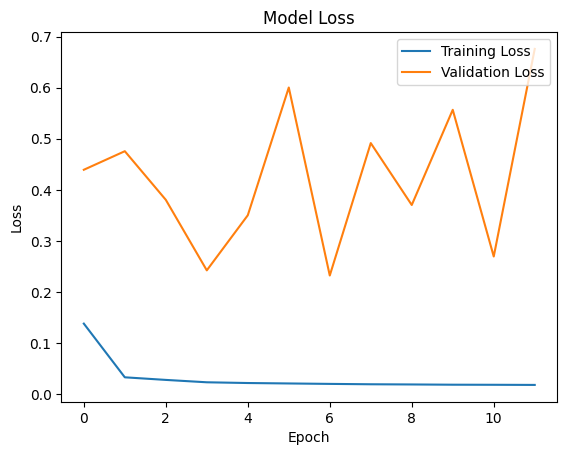

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Show the plot
plt.show()

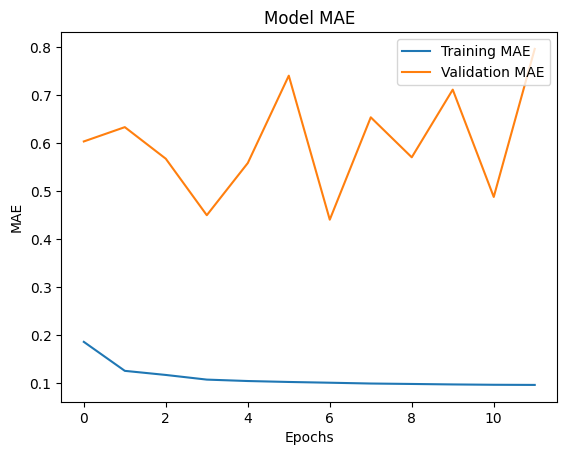

In [ ]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')

plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/best_model.keras')

In [ ]:
# Let's do the prediction and check performance metrics
predictions = model.predict(test_dataset)


predictions = y_scaler.inverse_transform(predictions)

2346/2346 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step


In [ ]:
predictions

array([[1.3960161],
       [3.133126 ],
       [3.6919293],
       ...,
       [2.2411706],
       [4.0486064],
       [3.065009 ]], dtype=float32)

In [ ]:
print(y_test_np.shape)
print(predictions.shape)

(300225, 1)
(300216, 1)


In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color='red', label='Real JamFactor')
    plt.plot(predicted, color='blue', label='Predicted JamFactor')
    plt.title('JamFactor Prediction')
    plt.xlabel('Time')
    plt.ylabel('JamFactor')
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is {}.".format(rmse))

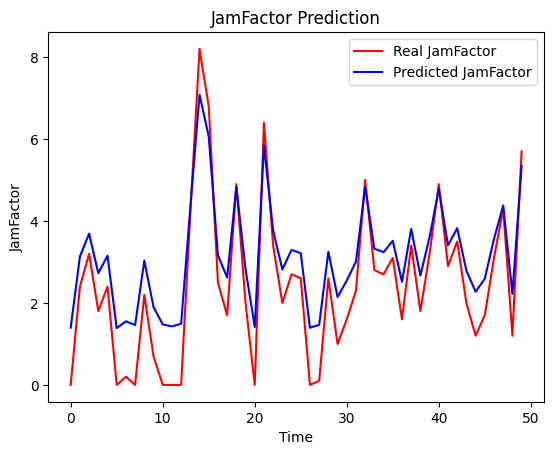

In [ ]:
plot_predictions(y_test_np[0:50, 0],predictions[0:50, 0])

In [ ]:
# Check the shapes of your test targets and predictions
print(f"y_test_np shape: {y_test_np.shape}")
print(f"test_predictions_unscaled shape: {predictions.shape}")

# Align the lengths by trimming the larger array
min_samples = min(len(y_test_np), len(predictions))

# Trim both arrays to have the same length
y_test_np_trimmed = y_test_np[:min_samples]
test_predictions_unscaled_trimmed = predictions[:min_samples]

# Now the shapes should match, so we can calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_np_trimmed, test_predictions_unscaled_trimmed))
print(f"The root mean squared error is {rmse}.")


y_test_np shape: (300225, 1)
test_predictions_unscaled shape: (300216, 1)
The root mean squared error is 1.0654697124566386.


In [ ]:
test.head()

,total_length,segment_length,speed,speedUncapped,freeFlow,jamFactor,confidence,latitude,longitude,hour,...,speed_kmh,freeFlow_kmh,jamFactor_lag_1,jamFactor_lag_2,jamFactor_lag_3,jamFactor_ma30,jamFactor_ma150,jamFactor_ma300,location_encoded,traversability_encoded
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-23 15:38:51,190.0,190.0,8.888889,8.888889,9.444445,0.0,0.98,24.73854,46.76030,15,...,32.000000,34.000002,1.5,1.0,1.0,1.116667,1.540667,1.732333,45.0,1.0
2024-09-23 15:38:51,976.0,976.0,7.777778,7.777778,11.111112,2.4,0.76,24.73016,46.76971,15,...,28.000001,40.000003,0.0,1.5,1.0,1.196667,1.537333,1.740333,56.0,1.0
2024-09-23 15:38:51,863.0,863.0,7.222222,7.222222,11.666667,3.2,0.74,24.71205,46.77871,15,...,26.000000,42.000001,2.4,0.0,1.5,1.276667,1.546000,1.751000,31.0,1.0
2024-09-23 15:38:51,1029.0,594.0,10.277778,10.277778,12.500000,1.8,0.78,24.68004,46.73677,15,...,37.000001,45.000000,3.2,2.4,0.0,1.293333,1.542000,1.736667,70.0,1.0
2024-09-23 15:38:51,1029.0,435.0,7.777778,7.777778,10.000000,2.4,0.78,24.68004,46.73677,15,...,28.000001,36.000000,1.8,3.2,2.4,1.303333,1.549333,1.741667,70.0,1.0


In [ ]:
model_features = ['total_length', 'speedUncapped', 'latitude', 'longitude', 'hour',
                  'day_of_week', 'week_of_year', 'isWeekend', 'Diff_jamFactor',
                  'speed_kmh', 'freeFlow_kmh', 'jamFactor_lag_1', 'jamFactor_lag_2',
                  'jamFactor_ma30', 'jamFactor_ma150', 'jamFactor_ma300', 'location_encoded']

# ROUTING PART

In [ ]:
# Load test dataset
test_df = test

# Prepare features and target
X_test = test_df[model_features]
y_test = test_df['jamFactor']

# Handle any missing values if necessary
X_test.fillna(0, inplace=True)

# Scale features
X_test_scaled = scaler.transform(X_test)

# Since your model expects sequences, create sequences
sequence_length = 10  # As per your model's requirement
X_test_sequences = []
for i in range(len(X_test_scaled) - sequence_length + 1):
    X_test_sequences.append(X_test_scaled[i:i+sequence_length])

X_test_sequences = np.array(X_test_sequences)

# Predict jam factors
predictions_scaled = model.predict(X_test_sequences)
predictions = y_scaler.inverse_transform(predictions_scaled)

# Adjust the test_df to align with predictions
test_df_aligned = test_df.iloc[sequence_length - 1:].reset_index(drop=True)

# Add predictions to the test_df
test_df_aligned['predicted_jamFactor'] = predictions.flatten()


<ipython-input-39-b49142c13a0a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(0, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


9382/9382 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step


In [ ]:
# Now, test_df_aligned contains the original data and the predicted jam factors
test_df_aligned.head()

,total_length,segment_length,speed,speedUncapped,freeFlow,jamFactor,confidence,latitude,longitude,hour,...,freeFlow_kmh,jamFactor_lag_1,jamFactor_lag_2,jamFactor_lag_3,jamFactor_ma30,jamFactor_ma150,jamFactor_ma300,location_encoded,traversability_encoded,predicted_jamFactor
0,436.0,28.0,7.500000,7.500000,7.777778,0.7,0.74,24.71742,46.77930,15,...,28.000001,2.2,0.0,0.2,1.120000,1.542667,1.712000,74.0,1.0,1.396016
1,1698.0,1698.0,27.222223,27.222223,24.722223,0.0,0.99,24.68004,46.73677,15,...,89.000003,0.7,2.2,0.0,1.083333,1.523333,1.705667,70.0,1.0,3.133126
2,345.0,345.0,15.000000,15.000000,12.222222,0.0,0.87,24.69169,46.79573,15,...,43.999999,0.0,0.7,2.2,0.986667,1.498667,1.705667,66.0,1.0,3.691929
3,257.0,257.0,16.666668,17.222223,16.666668,0.0,0.99,24.56496,46.76492,15,...,60.000005,0.0,0.0,0.7,0.986667,1.491333,1.703667,11.0,1.0,2.725578
4,161.0,161.0,11.111112,11.111112,19.166668,4.2,0.72,24.76514,46.76116,15,...,69.000005,0.0,0.0,0.0,1.113333,1.510000,1.715667,87.0,1.0,3.152423


In [ ]:
test_df_aligned.to_csv("test_data_with_pred.csv")

In [ ]:
# Create GeoDataFrame from test_df_aligned
test_gdf = gpd.GeoDataFrame(
    test_df_aligned,
    geometry=gpd.points_from_xy(test_df_aligned.longitude, test_df_aligned.latitude),
    crs='EPSG:4326'
)

# Define the coordinates for the points you want to visit (must be within the boundry box)
origin = (24.734047,46.755066)  # Start point
point_coords_1 = (24.718416,46.778369)  # Point 1
point_coords_2 = (24.701730,46.753650)  # Point 2
point_coords_3 = (24.721690,46.751590)  # Point 3

# Create a list of the waypoints (excluding the start point)
waypoints = [point_coords_1, point_coords_2, point_coords_3]

# Generate all possible orders for the waypoints
waypoint_permutations = list(itertools.permutations(waypoints))

# HERE API key
API_KEY = routing_key

# Define the destination (since it's a round trip, destination is the origin)
destination = origin

# Prepare routes list with different waypoint orders
routes_list = []
for idx, permutation in enumerate(waypoint_permutations):
    # Build the full coordinate list
    coords = [origin] + list(permutation) + [destination]
    routes_list.append({
        'route_index': idx,
        'coordinates': coords
    })


In [ ]:
routes_list

[{'route_index': 0,
  'coordinates': [(24.734047, 46.755066),
   (24.718416, 46.778369),
   (24.70173, 46.75365),
   (24.72169, 46.75159),
   (24.734047, 46.755066)]},
 {'route_index': 1,
  'coordinates': [(24.734047, 46.755066),
   (24.718416, 46.778369),
   (24.72169, 46.75159),
   (24.70173, 46.75365),
   (24.734047, 46.755066)]},
 {'route_index': 2,
  'coordinates': [(24.734047, 46.755066),
   (24.70173, 46.75365),
   (24.718416, 46.778369),
   (24.72169, 46.75159),
   (24.734047, 46.755066)]},
 {'route_index': 3,
  'coordinates': [(24.734047, 46.755066),
   (24.70173, 46.75365),
   (24.72169, 46.75159),
   (24.718416, 46.778369),
   (24.734047, 46.755066)]},
 {'route_index': 4,
  'coordinates': [(24.734047, 46.755066),
   (24.72169, 46.75159),
   (24.718416, 46.778369),
   (24.70173, 46.75365),
   (24.734047, 46.755066)]},
 {'route_index': 5,
  'coordinates': [(24.734047, 46.755066),
   (24.72169, 46.75159),
   (24.70173, 46.75365),
   (24.718416, 46.778369),
   (24.734047, 46.755

In [ ]:
# Request routes from the HERE API
for route in routes_list:
    try:
        # Construct the base parameters
        params = [
            ('transportMode', 'car'),
            ('origin', f'{origin[0]},{origin[1]}'),
            ('destination', f'{destination[0]},{destination[1]}'),
            ('apikey', API_KEY),
            ('return', 'polyline,summary')
        ]
        # Add via parameters without indices
        for waypoint in route['coordinates'][1:-1]:
            params.append(('via', f'{waypoint[0]},{waypoint[1]}'))

        # Send GET request
        response = requests.get('https://router.hereapi.com/v8/routes', params=params)

        if response.status_code == 200:
            route_data = response.json()
            route['route_data'] = route_data
        else:
            print(f"Error fetching route {route['route_index']}: {response.status_code} {response.text}")
    except Exception as e:
        print(f"Exception fetching route {route['route_index']}: {e}")

In [ ]:
route['route_data']

{'routes': [{'id': '898d3acd-edf0-4707-8a1f-17fc723a3771',
   'sections': [{'id': '7622978e-29ee-4e12-b4d2-9d2a7b0570ff',
     'type': 'vehicle',
     'departure': {'time': '2024-10-07T11:31:13+03:00',
      'place': {'type': 'place',
       'location': {'lat': 24.7340448, 'lng': 46.7550673},
       'originalLocation': {'lat': 24.7340469, 'lng': 46.7550659}}},
     'arrival': {'time': '2024-10-07T11:37:17+03:00',
      'place': {'type': 'place',
       'location': {'lat': 24.7216607, 'lng': 46.751605},
       'originalLocation': {'lat': 24.72169, 'lng': 46.7515899},
       'waypoint': 0}},
     'summary': {'duration': 364, 'length': 2336, 'baseDuration': 330},
     'polyline': 'BG610lvB2v2l5CpFxIrYzoBvb_sB_nBgU3mB0UrJnQ_EAvC8BTsEoLwR4hBk1BrEgFvb0Uj6BssBjXwR3_BkwBzUgPvMsJ_OgK_E4D3DA3Snfzev0B_J7VvH3IvM3c7GnQzF3NvHjS3I4DnkBkSrxBsd3hBsOvbsO_J0FrTjrBvCjIjN_dvH3S3crlC3X7zB3NnkB_EzKjD3IrEnLzFvM3hBgPjDoBhDlH',
     'transport': {'mode': 'car'}},
    {'id': '0e21e9bf-4172-449f-9485-938cb93984a3

In [ ]:
import json

for route in routes_list[2:]:
    route_data = route.get('route_data')
    print(f"\nRoute {route['route_index']} data:")
    print(json.dumps(route_data, indent=2))



Route 2 data:
{
  "routes": [
    {
      "id": "3c28e383-3962-4fa8-a36a-9ec09a31beb0",
      "sections": [
        {
          "id": "62a0afd4-0506-414b-a5f7-901864ac1de8",
          "type": "vehicle",
          "departure": {
            "time": "2024-10-07T11:31:12+03:00",
            "place": {
              "type": "place",
              "location": {
                "lat": 24.7340448,
                "lng": 46.7550673
              },
              "originalLocation": {
                "lat": 24.7340469,
                "lng": 46.7550659
              }
            }
          },
          "arrival": {
            "time": "2024-10-07T11:43:22+03:00",
            "place": {
              "type": "place",
              "location": {
                "lat": 24.7017608,
                "lng": 46.7537025
              },
              "originalLocation": {
                "lat": 24.70173,
                "lng": 46.75365
              },
              "waypoint": 0
            }
      

In [ ]:

# Process each route
# Initialize list to store route metrics
route_metrics = []

for route in routes_list:
    print(f"\nProcessing Route {route['route_index']}...")
    route_data = route.get('route_data')
    if not route_data:
        print(f"No route data for route {route['route_index']}")
        continue

    # Check if routes are available
    if not route_data.get('routes'):
        print(f"No routes found for route {route['route_index']}")
        continue

    # Extract and decode polylines from all sections
    try:
        coordinates = []
        for section in route_data['routes'][0]['sections']:
            polyline = section['polyline']
            # Decode the polyline using HERE's flexible polyline decoder
            section_coords = fp.decode(polyline)
            coordinates.extend(section_coords)
    except Exception as e:
        print(f"Error processing route {route['route_index']}: {e}")
        continue

    # Convert coordinates to DataFrame
    route_coords = pd.DataFrame(coordinates, columns=['lat', 'lng'])

    # Create GeoDataFrame for route points
    route_gdf = gpd.GeoDataFrame(
        route_coords,
        geometry=gpd.points_from_xy(route_coords.lng, route_coords.lat),
        crs='EPSG:4326'
    )

    # Prepare coordinate arrays for BallTree
    # Convert lat/lng to radians
    route_points_rad = np.deg2rad(route_gdf[['lat', 'lng']].values)
    test_points_rad = np.deg2rad(test_gdf[['latitude', 'longitude']].values)

    # Build BallTree using haversine metric
    tree = BallTree(test_points_rad, metric='haversine')

    # Query for the nearest neighbor
    distances, indices = tree.query(route_points_rad, k=1)

    # Get the matched points
    matched_points = test_gdf.iloc[indices.flatten()].reset_index(drop=True)

    # Add predicted jam factors to route_gdf
    route_gdf['predicted_jamFactor'] = matched_points['predicted_jamFactor'].values

    # Handle any missing values
    route_gdf.fillna({'predicted_jamFactor': route_gdf['predicted_jamFactor'].mean()}, inplace=True)

    # Calculate total and average predicted jam factors
    total_jam_factor = route_gdf['predicted_jamFactor'].sum()
    average_jam_factor = route_gdf['predicted_jamFactor'].mean()

    print(f"Route {route['route_index']} - Total Predicted Jam Factor: {total_jam_factor}")

    # Store route metrics
    route_metrics.append({
        'route_index': route['route_index'],
        'total_jam_factor': total_jam_factor,
        'average_jam_factor': average_jam_factor,
        'route_data': route_data,
        'route_gdf': route_gdf,
        'coordinates': route['coordinates']
    })

# Determine the best route based on the minimum total jam factor
if route_metrics:
    best_route = min(route_metrics, key=lambda x: x['total_jam_factor'])

    print(f"\nBest Route Index: {best_route['route_index']}")
    print(f"Waypoints Order: {best_route['coordinates'][1:-1]}")
    print(f"Total Predicted Jam Factor: {best_route['total_jam_factor']}")
else:
    print("No routes were successfully fetched.")


Processing Route 0...
Route 0 - Total Predicted Jam Factor: 813.6636962890625

Processing Route 1...
Route 1 - Total Predicted Jam Factor: 1019.498291015625

Processing Route 2...
Route 2 - Total Predicted Jam Factor: 837.0810546875

Processing Route 3...
Route 3 - Total Predicted Jam Factor: 1097.01611328125

Processing Route 4...
Route 4 - Total Predicted Jam Factor: 1181.440673828125

Processing Route 5...
Route 5 - Total Predicted Jam Factor: 810.577392578125

Best Route Index: 5
Waypoints Order: [(24.72169, 46.75159), (24.70173, 46.75365), (24.718416, 46.778369)]
Total Predicted Jam Factor: 810.577392578125


In [ ]:
# Decode the polylines from all sections of the best route
best_route_data = best_route['route_data']

# Collect all coordinates from the route's sections
coordinates = []
for section in best_route_data['routes'][0]['sections']:
    polyline = section['polyline']
    # Decode the polyline using HERE's flexible polyline decoder
    section_coords = fp.decode(polyline)
    coordinates.extend(section_coords)

# Create a map centered on the origin
m = folium.Map(location=origin, zoom_start=13)

# Add the route line to the map
folium.PolyLine(locations=coordinates, color='blue', weight=5, opacity=0.7).add_to(m)

# Add a marker for the origin
folium.Marker(location=origin, popup='Origin', icon=folium.Icon(color='green')).add_to(m)

# Add markers for the waypoints
for idx, waypoint in enumerate(best_route['coordinates'][1:-1]):
    folium.Marker(location=waypoint, popup=f'Waypoint {idx+1}', icon=folium.Icon(color='red')).add_to(m)

# Display the map
m

#THANK YOU :)